# Content

In this notebook we generate some random graphs from $4$ different families (Erdos-Renyi, stochastic block model, configuration model and geometric model) and make them temporal associating to each edge a temporal series of an edge of the *SP* called `SFHH`. Each graph has a varying number of nodes. We then use our distance definition to cluster the graphs according to their generative model.

In [1]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import normalized_mutual_info_score as NMI
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt

import sys
sys.path += ['Package']

from MatrixDistance import *
from GraphCreation import *
from Utilities import *

import warnings
warnings.filterwarnings("ignore")

In [2]:
def MakeTemporal(dft, timeFR):
    '''This function takes an edge list (dft) in the form of a pandas dataframe and all the time series stored in
    timeFR and creates a temporal graph'''

    idx1 = []
    idx2 = []
    tv = []

    # map each edge to one of the edges from time_FR
    for x in range(len(dft)):
        i, j = dft.iloc[x].values
        q = np.random.randint(len(timeFR))

        for t in timeFR[q]:
            idx1.append(i)
            idx2.append(j)
            tv.append(t)

    # build the temporal dataframe
    DFT = pd.DataFrame(np.array([idx1, idx2, tv]).T, columns = ['i', 'j', 't'])
    DFT.t -= DFT.t.min()
    DFT.t /= 10*60 # 10 minutes time resolution
    DFT.t = DFT.t.astype(int)
    DFT['τ'] = 1
    DFT = DFT.groupby(['i', 'j', 't']).sum().reset_index()
    
    return DFT

def CosSim(x,y):
    '''Cosine similarity between two vectors'''
    return x@y/np.sqrt(x@x*y@y)


### Get the daily activity patterns for each edge in `SFHH`

In [3]:
# we build df_SP so that it contains (i,j,t, day)
df_SP = pd.read_csv('../Codes/Data/SPData/SFHH.dat', header = None, sep = ' ', names = ['t', 'i', 'j'])
df_SP['day'] = pd.to_datetime(df_SP.t, unit = 's')
df_SP['day'] = df_SP.day.dt.day
all_pairs = df_SP.groupby(['i', 'j', 'day']).size().reset_index()[['i', 'j', 'day']].values
df_SP.set_index(['i', 'j', 'day'], inplace = True)

timeF = []

# a pair is in the form (i, j, day) and timeF stores all the interactions between i and j on day t
for x, pair in enumerate(all_pairs):
    print(str(np.round((x+1)/len(all_pairs)*100,2)) + ' %', end = '\r')
    i, j, t = pair
    timeF.append(df_SP.loc[i, j, t].t.values)
    
# we then construct time FR that for each (i,j,t) stores the edge time-line, centered to 00:00 of the corresponding day 
timeFR = [[] for x in range(len(timeF))]

for a, T in enumerate(timeF):
    print(str(np.round((a+1)/len(all_pairs)*100,2)) + ' %', end = '\r')
    for t in T:
        if (pd.to_datetime(t, unit = 's') - pd.to_datetime('1970-01-01 08:00:00')).days == 1:

            tt = (pd.to_datetime(t, unit = 's') - pd.to_datetime('1970-01-02 08:00:00')).total_seconds()
            
        else:
            tt = (pd.to_datetime(t, unit = 's') - pd.to_datetime('1970-01-01 08:00:00')).total_seconds()
            
        timeFR[a].append(tt)

In [4]:
# We generate a sequence of temporal graphs with n0 = 1000 as the average number of nodes and store them in the 
# list DFT. For each type we generate 250 graphs

n = 1000
n_graphs = 1

DFT = []
size = []

### DCSBM
k = 5
c_in = 25
c_out = 1
C = np.ones((k,k))*c_out
C += np.diag(np.ones(k))*(c_in - c_out)
c = (c_in + (k-1)*c_out)/k
symmetric = True
make_connected = True



for i in range(n_graphs):
    print(str(100*(i+1)/n_graphs) + ' %' , end = '\r')
    
    θ = np.ones(n)
    ℓ = np.zeros(n)
    for i in range(k):
        ℓ[i*int(n/k): (i+1)*int(n/k)] = i
    ℓ = ℓ.astype(int)

    args = (C, c, ℓ, θ, symmetric, make_connected)
    dft = DCSBM(args)
    DFT.append(MakeTemporal(dft, timeFR))
    size.append(n)
print('\n')
    
### ER
k = 1
C = np.ones((k,k))*c

for i in range(n_graphs):
    print(str(100*(i+1)/n_graphs) + ' %' , end = '\r')
    
    ℓ = np.zeros(n).astype(int)
    θ = np.ones(n)
    args = (C, c, ℓ, θ, symmetric, make_connected)

    dft = DCSBM(args)
    DFT.append(MakeTemporal(dft, timeFR))
    size.append(n)
print('\n')

    
### Configuration model
for i in range(n_graphs):
    print(str(100*(i+1)/n_graphs) + ' %' , end = '\r')
    
    θ = np.random.uniform(3,10, n)**4
    θ = θ/np.mean(θ)
    ℓ = np.zeros(n).astype(int)
    args = (C, c, ℓ, θ, symmetric, make_connected)

    
    dft = DCSBM(args)
    DFT.append(MakeTemporal(dft, timeFR))
    size.append(n)
print('\n')

### Geometric model
β = 20

for i in range(n_graphs):
    print(str(100*(i+1)/n_graphs) + ' %' , end = '\r')
    
    r = np.random.uniform(0, 1, n)
    θ = np.random.uniform(0, 2*np.pi, n)
    X = np.zeros((n, 2))
    X[:,0] = r*np.cos(θ)
    X[:,1] = r*np.sin(θ)
    args = (X, c, β)

    
    dft = GeometricModel(args)
    DFT.append(MakeTemporal(dft, timeFR))
    
    size.append(n)

100.0 %

100.0 %

100.0 %



In [15]:
αv = np.linspace(0,1,15)
n_iter = 25

dist = [np.zeros((len(αv), n_iter)) for i in range(len(DFT))]

for kk in range(len(DFT)):
    df = copy(DFT[kk])
    n = len(np.unique(df[['i', 'j']]))
    

    for a, α in enumerate(αv):
        np.random.seed(123)
        X = GraphDynamicEmbedding(df, dim = 32, n = n, verbose = False) 

        all_nodes = np.sort(np.unique(df[['i', 'j']]).astype(int))
        n = len(all_nodes)

        for i in range(n_iter):
            np.random.seed()
            df = copy(DFT[kk])
            print(f'graph: {kk+1}; alpha:{α}; iter: {i+1}/{n_iter}', end = '\r')
            all_nodes_shuffled = copy(all_nodes)
            idx = np.random.binomial(1, α, n) == 1
            to_be_shuffled = all_nodes_shuffled[idx]
            np.random.shuffle(to_be_shuffled)
            all_nodes_shuffled[idx] = to_be_shuffled
            NodeMapper = dict(zip(all_nodes, all_nodes_shuffled))

            df.i = df.i.map(lambda x: NodeMapper[x])
            df.j = df.j.map(lambda x: NodeMapper[x])

            np.random.seed(123)
            Y = GraphDynamicEmbedding(df, dim = 32, n = n, verbose = False)
            dist[kk][a,i] = EmbDistance(X, Y, distance_type = 'matched')/n

In [16]:
# names = ['DCSBM', 'ER', 'Configuration model', 'GeometricModel']

# for i, name in enumerate(names):
#     pd.DataFrame(dist[i]).to_csv(f'Data/Partially_shuffled_nodes/{name}.csv', index = False)

In [11]:
# names = ['DCSBM', 'ER', 'Configuration model', 'GeometricModel']
# dist = []

# for i, name in enumerate(names):
#     dist.append(pd.read_csv(f'Data/Partially_shuffled_nodes/{name}.csv'))

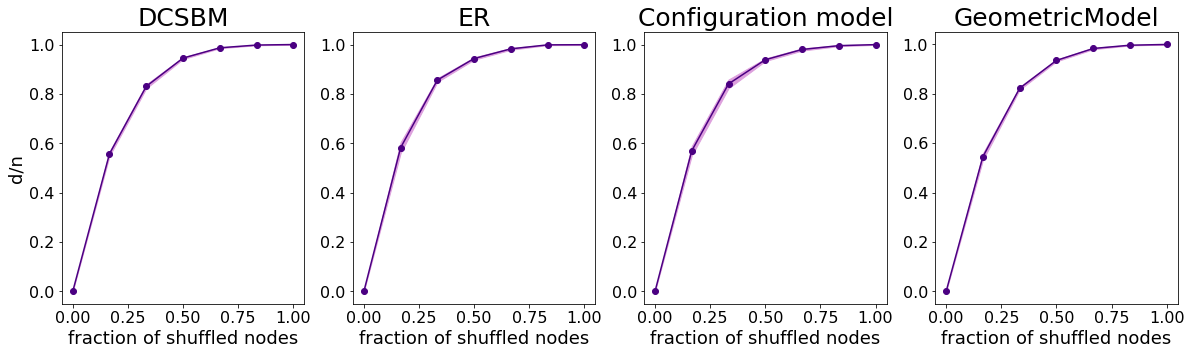

In [13]:
ngraphs = 4
αv = np.linspace(0,1,7)

fig, ax = plt.subplots(1, ngraphs, figsize = (5*ngraphs, 5))



for i in range(ngraphs):

    d = dist[i]/dist[i].max().mean()
    m = np.mean(d, axis = 1)
    s = np.std(d, axis = 1)
    ax[i].plot(αv, m, color = 'indigo', marker = 'o')
    ax[i].fill_between(αv,  m-s, m+s, color = 'plum')


    ax[i].set_title(names[i], fontsize = 25)
    ax[i].set_xlabel('fraction of shuffled nodes', fontsize = 18)
    ax[i].tick_params(axis='both', which='major', labelsize=16)
    
    
ax[0].set_ylabel('d/n', fontsize = 18)
    
plt.show();